In [17]:
import json
import numpy as np
import matplotlib.pyplot as plt
from components_ import scene_creator, processor_creator, wdrc
from lyd import utils, processing
from scipy.io import wavfile
from lyd import wdrc

import os

import markdown

def audio_entry(name):
    string = f'''<audio src="assets/spatial_independent/{name}"  controls style="width: 250px">'</audio>'''
    return string
from IPython.display import HTML, display

# Generate data

In [18]:
# Initialize objects
stimuli = scene_creator(2,spatial=True)
pL = processor_creator(fs=16e3)
pF = processor_creator(fs=16e3)
pS = processor_creator(fs=16e3)
pA = processor_creator(fs=16e3)


# Level adjuster
level_adjuster = processing.AdjustLevel(-30)

# Stimuli parameters
stimuli.update_param('signal_level',65)
stimuli.update_param('noise_type','Stationary')

# Initialize processes
pL.update_param('thr',100)
pL.update_param('ratio',1)
pL.update_param('wdrc','Slow Acting')
pL.update_param('b_link','False')

pF.update_param('thr',45)
pF.update_param('ratio',3)
pF.update_param('wdrc','Fast Acting')
pF.update_param('b_link','False')

pS.update_param('thr',45)
pS.update_param('ratio',3)
pS.update_param('wdrc','Slow Acting')
pS.update_param('b_link','False')

pA.update_param('thr',45)
pA.update_param('ratio',3)
pA.update_param('wdrc','Aware')
pA.update_param('b_link','False')

f_wdrc = wdrc.WDRC(atk=5e-3,rel=50e-3,thr=45,ratio=3,fs=16e3)
b_wdrc = wdrc.WDRC(atk=5e-3,rel=2000e-3,thr=45,ratio=3,fs=16e3)

# Create dictionaries to iterate through
wdrc_dict = {
    'lin':pL,
    'fast':pF,
    'slow':pS,
    'aware':pA,
    'ideal':'ideal'
}
rooms = {
    'Anechoic' : 'Anechoic',
    'Reverberant' : 'D'
}
snrs = {
    'inf' : 300,
    'high' : 16,
    'medium' : 6,
    'low' : 0
}
nrs = {
    'nr_off' : "None",
    'nr_on' : "Moderate"
}

noise_types = {
    'Stationary' : 'Stationary',
    'Modulated' : 'Modulated'
}

# Initialize table
data = []
data.append([
    '<b>Scene</b> [Room_noise_snr_noise-reduction]',
    '<b>Linear gain</b>',
    '<b>Fast acting WDRC</b>',
    '<b>Slow acting WDRC</b>',
    '<b>Scene-aware WDRC</b>',
    '<b><i>ideal WDRC</i></b>'])

# Iterate over conditions
for noise_key, noise_val in noise_types.items():
    stimuli.update_param('noise_type',noise_val)

    for nr_key, nr_val in nrs.items():
        pL.update_param('nr',nr_val)
        pF.update_param('nr',nr_val)
        pS.update_param('nr',nr_val)
        pA.update_param('nr',nr_val)

        # Iterate over rooms
        for room_key, room_val in rooms.items():
            stimuli.update_param('room',room_val)
            
            # Iterate over snr
            for snr_key, snr_val in snrs.items():
                stimuli.update_param('snr',snr_val)
                
                # Generate stimuli
                stimuli.gen_scene()
                f,b,mix = stimuli.stim.transform()

                # Save input
                #mix_adjusted = level_adjuster(mix)
                name = f"{room_key.lower()}-SNR_{snr_key}.wav"
            
                
                row = []
                #row.append(f"{room_key.lower()}-SNR_{snr_key}-nr_{nr_val}")
                row.append(f"<small><b>ROOM</b>-{room_key.lower()}-<b>NOISE_</b>{noise_key}<br><b>SNR_</b>{snr_key}-<b>NR</b>_{nr_val}</small>")
                #row.append(audio_entry(name))

                # Iterate over compressors
                for wdrc_key, wdrc_val in wdrc_dict.items():

                    if wdrc_key != 'ideal':
                        wdrc_val.gen_sys()
                        s = wdrc_val.s
                        
                        # Process signal
                        xc = s.transform(mix,b)
                    else:
                        fc = f_wdrc.transform(f)
                        bc = b_wdrc.transform(b)
                        if nr_key != 'None':
                            bc *= utils.from_dB(-12)
                        xc = fc+bc



                    xc_adjusted = level_adjuster(xc)[:,8000:]

                    if xc_adjusted.min() < -0.95:
                        print(xc_adjusted.min())
                    if xc_adjusted.max() > 0.95:
                        print(xc_adjusted.max())

                    name = f"{room_key.lower()}-NOISE_{noise_key}-SNR_{snr_key}-NR_{nr_key}-wdrc_{wdrc_key}"
                    wavfile.write("docs/assets/spatial_independent/"+name+".wav",16000,xc_adjusted.T.astype(np.float32))
                    row.append(audio_entry(name+".mp3"))

                #name = f"{room_key.lower()}-SNR_{snr_key}.wav"
                name = f"{room_key.lower()}-NOISE_{noise_key}-SNR_{snr_key}"
                data.append(row)
        
        data.append(['--','--','--','--','--'])

# Convert to mp3
os.system('for i in docs/assets/spatial_independent/*.wav; do ffmpeg -i "$i" -ab 320k "${i%.*}.mp3" -loglevel quiet; done')

# Delete wav files
os.system("rm docs/assets/spatial_independent/*.wav")

        


100.0
45.0
45.0
45.0


0

# Audio 

### Properties
- *Stationary noise (ICRA01)*
- Rooms: 
    - Anechoic (Surrey Anechoic), or
    - Reverberant (Surrey Room D)
- Speech: TIMIT
- Speech level: 65 dB RMS
- SNR: 
    - inf, or
    - high: 16 dB SNR, or
    - medium: 6 dB SNR, or
    - low: 0 dB SNR
- Noise reduction
    - None, or
    - LogMMSE, 24dB maximum attenuation
- WDRC
    - Attack: 5ms
    - Release: 50ms (fast), 2000ms (slow)
    - Ratio: 3:1
    - Threshold: 45dB 
    - #Channels: 7




In [19]:
output = markdown.markdown('''
### Spatially separated, bilateral independent processing
- **Noise**: 
    - Stationary noise (ICRA01), or
    - Modulated noise (ICRA06)
- **Rooms:** 
    - Anechoic (Surrey Anechoic), or
    - Reverberant (Surrey Room D)
- **Speech:** 
    - source: TIMIT
    - level: 65 dB RMS
- **SNR: **
    - inf, or
    - high: 16 dB SNR, or
    - medium: 6 dB SNR, or
    - low: 0 dB SNR
- **Noise reduction**
    - None, or
    - LogMMSE, 24dB maximum attenuation
- **WDRC**
    - Attack: 5ms
    - Release: 50ms (fast), 2000ms (slow)
    - Ratio: 3:1
    - Threshold: 45dB 
    - number of channels: 7
    - Scene-aware: Adaptively changes release time constant based on foreground detection
    - *Ideal* WDRC: Applies fast acting compression on the foreground, and slow-acting compression on the background before mixing. When NR is activated, the background is attenuated by 10dB.
''')



In [20]:
f = open("docs/demo_page3.html","w")

f.write("<!DOCTYPE html>")
f.write("<html>")
f.write('<body style="font-family: sans-serif">')
f.write('<br>')
f.write('<a href="index.html">Back</a>')
f.write('<br>')

f.write(output)

f.write(
    '<table class = "center"><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       ))

f.write("</body>")
f.write("</html>")

f.close()

In [62]:
display(HTML(
   '<table class = "center"><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

Scene,Linear gain,Fast acting WDRC,Slow acting WDRC,Scene-aware WDRC
anechoic-NOISE_Stationary-SNR_inf-NR_None,',',','
anechoic-NOISE_Stationary-SNR_high-NR_None,',',','
anechoic-NOISE_Stationary-SNR_medium-NR_None,',',','
anechoic-NOISE_Stationary-SNR_low-NR_None,',',','
reverberant-NOISE_Stationary-SNR_inf-NR_None,',',','
reverberant-NOISE_Stationary-SNR_high-NR_None,',',','
reverberant-NOISE_Stationary-SNR_medium-NR_None,',',','
reverberant-NOISE_Stationary-SNR_low-NR_None,',',','
--,--,--,--,--
anechoic-NOISE_Stationary-SNR_inf-NR_Moderate,',',','


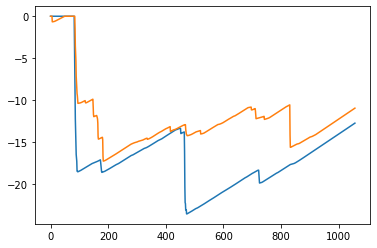

In [5]:
G = pS.s.compressor.G

plt.plot(utils.to_dB(G[0,75,:]))
plt.plot(utils.to_dB(G[1,75,:]))

In [24]:
pS.s.compressor.b_link

False

In [61]:
import markdown
output = markdown.markdown('''
### Properties
- Stationary noise (ICRA01)
- Rooms: 
    - Anechoic (Surrey Anechoic), or
    - Reverberant (Surrey Room D)
    - Speech: TIMIT
- Speech level: 65 dB RMS
- SNR: 
    - inf, or
    - high: 16 dB SNR, or
    - medium: 6 dB SNR, or
    - low: 0 dB SNR
- Noise reduction
    - None, or
    - LogMMSE, 24dB maximum attenuation
- WDRC
    - Attack: 5ms
    - Release: 50ms (fast), 2000ms (slow)
    - Ratio: 3:1
    - Threshold: 45dB 
    - #Channels: 7
''')


In [62]:
output

'<h3>Properties</h3>\n<ul>\n<li>Stationary noise (ICRA01)</li>\n<li>Rooms: <ul>\n<li>Anechoic (Surrey Anechoic), or</li>\n<li>Reverberant (Surrey Room D)</li>\n<li>Speech: TIMIT</li>\n</ul>\n</li>\n<li>Speech level: 65 dB RMS</li>\n<li>SNR: <ul>\n<li>inf, or</li>\n<li>high: 16 dB SNR, or</li>\n<li>medium: 6 dB SNR, or</li>\n<li>low: 0 dB SNR</li>\n</ul>\n</li>\n<li>Noise reduction<ul>\n<li>None, or</li>\n<li>LogMMSE, 24dB maximum attenuation</li>\n</ul>\n</li>\n<li>WDRC<ul>\n<li>Attack: 5ms</li>\n<li>Release: 50ms (fast), 2000ms (slow)</li>\n<li>Ratio: 3:1</li>\n<li>Threshold: 45dB </li>\n<li>\n<h1>Channels: 7</h1>\n</li>\n</ul>\n</li>\n</ul>'

In [34]:
print(properties)

<pre><code>### Properties
- Stationary noise (ICRA01)
- Rooms: 
    - Anechoic (Surrey Anechoic), or
    - Reverberant (Surrey Room D)
- Speech: TIMIT
- Speech level: 65 dB RMS
- SNR: 
    - inf, or
    - high: 16 dB SNR, or
    - medium: 6 dB SNR, or
    - low: 0 dB SNR
- Noise reduction
    - None, or
    - LogMMSE, 24dB maximum attenuation
- WDRC
    - Attack: 5ms
    - Release: 50ms (fast), 2000ms (slow)
    - Ratio: 3:1
    - Threshold: 45dB 
    - #Channels: 7
</code></pre>


In [31]:
f,b,m = stimuli.stim.transform()
wd = pF.s

M = wd(m)
G = wd.compressor.G
wd.compressor.b_link

False

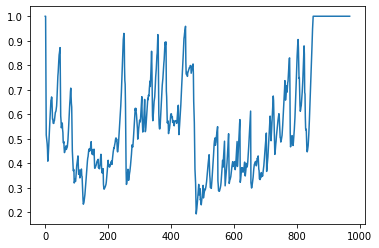

In [43]:
fast = wdrc.WDRC(fs=16e3,b_link=False)

M = fast(m)

plt.plot(fast.G[0,50])

In [44]:

X = fast.STFT(m)
G = fast.interpolate(fast.gain,X.shape,fast.FB.f_center,fast.STFT.f)

In [45]:
G.shape

(2, 129, 969)

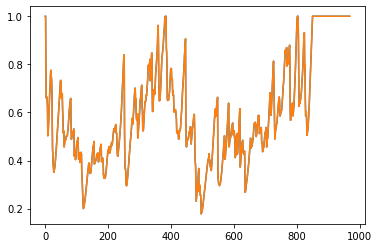

In [49]:
plt.plot(fast.gain[0,4])
plt.plot(fast.gain[1,4])

In [61]:
x = mix
X = fast.STFT(x)
Xfb = fast.FB(X)
fast.ENV.mask = np.zeros_like(Xfb)
Xenv = 20*np.log10(fast.ENV(Xfb))
gain = fast.DYN(Xenv)


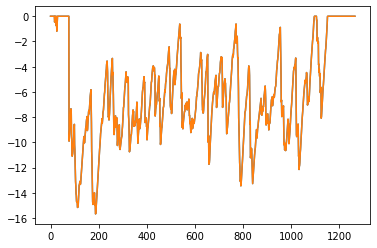

In [64]:
plt.plot(gain[0,3])
plt.plot(gain[1,3])